# **Adverse Drug Events (ADE Classifier)**


## What this project is about

- **Task:** Binary text classification to detect **Adverse Drug Events (ADE)** in short clinical/biomedical texts.  
- **Goal:** Choose a model that **prioritizes recall** (do not miss ADEs) while keeping precision competitive for downstream review.
- **Data:** Curated corpus split into **train / validation / test** with stable IDs for reproducibility.
- **Model families compared (5 total):**
  - **Baselines (TF-IDF):** Logistic Regression, Linear SVM (calibrated).
  - **Transformers:** DistilBERT, BioBERT, PubMedBERT.

### Selection policy (fixed before looking at test)
- Pick a **threshold on validation** to reach **recall ≥ 0.90**.  
- If multiple thresholds qualify, prefer **higher precision**, tie-break by **F1**, then **PR-AUC**.  
- Score **test at that same validation-chosen threshold** for a fair comparison.


## Why ADE detection matters

- **Patient safety:** ADEs are a major source of morbidity and cost. Early detection in text (case reports, narratives, notes) helps surface safety signals faster.
- **Under-reporting:** Many ADEs are buried in free-text rather than structured fields. Automated triage can raise recall, route items to experts, and speed pharmacovigilance.
- **Triage, not diagnosis:** The classifier helps **prioritize** likely ADE mentions. It is not a clinical device and should feed a human-in-the-loop workflow.


## Notebooks, Project Structure, and Demo

### Notebooks
- `00_main.ipynb` — narrative report and final results — this notebook: https://colab.research.google.com/drive/1VdvHcuBEOoNfz0m4SP5nCG6Mx95_i3kW?usp=sharing

- Notebook 1: Data prep and split — [Colab](https://colab.research.google.com/drive/1sLuzWFUAwlSKXFqqI851ZwTSgdnUzPzp)  
  `01_Data_Prep.ipynb` — cleaning, leakage guard, stratified split, class weights

- Notebook 2: EDA — [Colab](https://colab.research.google.com/drive/1ixGcdCv_moL-CagZ51qLHigC-btEgLCk)  
  `02_eda.ipynb` — exploratory analysis and figures

- Notebook 3: Baselines (TF-IDF LR/SVM) — [Colab](https://colab.research.google.com/drive/1swGOnQTKFJ7AdwWeURLvads2kpBqzPDn)  
  `03_Baselines_TFIDF_LR_SVM.ipynb` — TF-IDF models and calibrated probabilities

- Notebook 4: DistilBERT — [Colab](https://colab.research.google.com/drive/1UgOQA5L0S4m-OsTCVY9f7aONCPcykmDV)  
  `04_transformer_distilbert.ipynb` — DistilBERT training and evaluation

- Notebook 5: BioBERT — [Colab](https://colab.research.google.com/drive/1LQNZSgwLzN2GjOGNEZjUZJfOsTvFC6yl)  
  `05_transformer_biobert.ipynb` — BioBERT training and evaluation

- Notebook 6: PubMedBERT — [Colab](https://colab.research.google.com/drive/1C3idcaweut3V4hxMf5zcCIPhbJTmDJVb)  
  `06_pubmedbert_training.ipynb` — PubMedBERT training and evaluation

- Notebook 7: Model comparison — [Colab](https://colab.research.google.com/drive/13uH5BAeFE8lAn_SQUXn-fzp_viRNqXMh)  
  `07_model_comparison.ipynb` — threshold policy, metrics table, comparison plots

**Project folder:** https://drive.google.com/drive/folders/1y72j7f5j7YiLj2Wj82Pk_Rp2ww0fxE8w?usp=sharing

## **Live demo**
[![Space badge](https://img.shields.io/badge/%F0%9F%A4%97%20Space-ADE--PubMedBERT-blue)](https://huggingface.co/spaces/Daregay/ade_pubmedbert_demo)



In [ ]:
from pathlib import Path
import os, sys, importlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
CANDIDATES = [
    Path("/content/drive/MyDrive/masters_math/capestone/Final_project/Final_project"),
    Path("/content/drive/masters_math/capestone/Final_project/Final_project"),
]
PROJECT_ROOT = next((p for p in CANDIDATES if (p/"src"/"utilities.py").exists()), None)
assert PROJECT_ROOT, "Couldn't find src/utilities.py. Check the Drive path."
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
import importlib, src; importlib.reload(src)

SRC_DIR = PROJECT_ROOT / "src"
init_file = SRC_DIR / "__init__.py"
if not init_file.exists():
    init_file.write_text(
        "from .utilities import *\n"
        "from .plots import *\n"
        "from .hf_utils import *\n"
    )
from src import ensure_dir

ARTIFACTS_DIR = ensure_dir(PROJECT_ROOT / "artifacts")
PLOTS_DIR     = ensure_dir(PROJECT_ROOT / "plots")
TRANS_DIR     = ensure_dir(ARTIFACTS_DIR / "transformers" / "biobert")

In [ ]:
def show_img(path, width=600):
    display(Image(filename=str(path), width=width))

## Data source and provenance

- **Source:** Public dataset hosted on Hugging Face: `SetFit/ade_corpus_v2_classification`.
- **Origin:** A sentence-level reframing of the **ADE Corpus v2** (case reports from the biomedical literature). Sentences are labeled as:
  - **Related** → the sentence expresses an ADE,
  - **Not-Related** → no ADE expressed.



In [ ]:
# source HuggingFace parquet endpoints
train_url = "https://huggingface.co/api/datasets/SetFit/ade_corpus_v2_classification/parquet/default/train/0000.parquet"
test_url  = "https://huggingface.co/api/datasets/SetFit/ade_corpus_v2_classification/parquet/default/test/0000.parquet"

train_full = pd.read_parquet(train_url)
test_df    = pd.read_parquet(test_url)

train_full.head(5)

,text,label,label_text
0,"On cessation of the injections, the retrocorne...",0,Not-Related
1,Median patient age was 52 years.,0,Not-Related
2,A whole brain irradiation was performed for 37...,0,Not-Related
3,Complex biochemical syndrome of hypocalcemia a...,0,Not-Related
4,The fastidious organism grew only on buffered ...,0,Not-Related


In [ ]:
train_full.shape, test_df.shape

((17637, 3), (5879, 3))

## Notebook 1
- Data prep and split — [Colab](https://colab.research.google.com/drive/1sLuzWFUAwlSKXFqqI851ZwTSgdnUzPzp)

#**Data preparation and splitting**

- Load ADE Corpus V2 (sentence classification) from the Hugging Face parquet endpoints.
- Standardize columns, drop empty text, lightly clean whitespace, and add a normalized text field for de-duplication.
- Remove exact duplicates and resolve any conflicting labels by majority vote on the normalized text.
- Guard against leakage by removing training rows whose normalized text appears in test.
- Make a stratified split of training into train and validation, assign stable ids, compute class weights, and save artifacts.
- fixed seed (42) across all notebooks

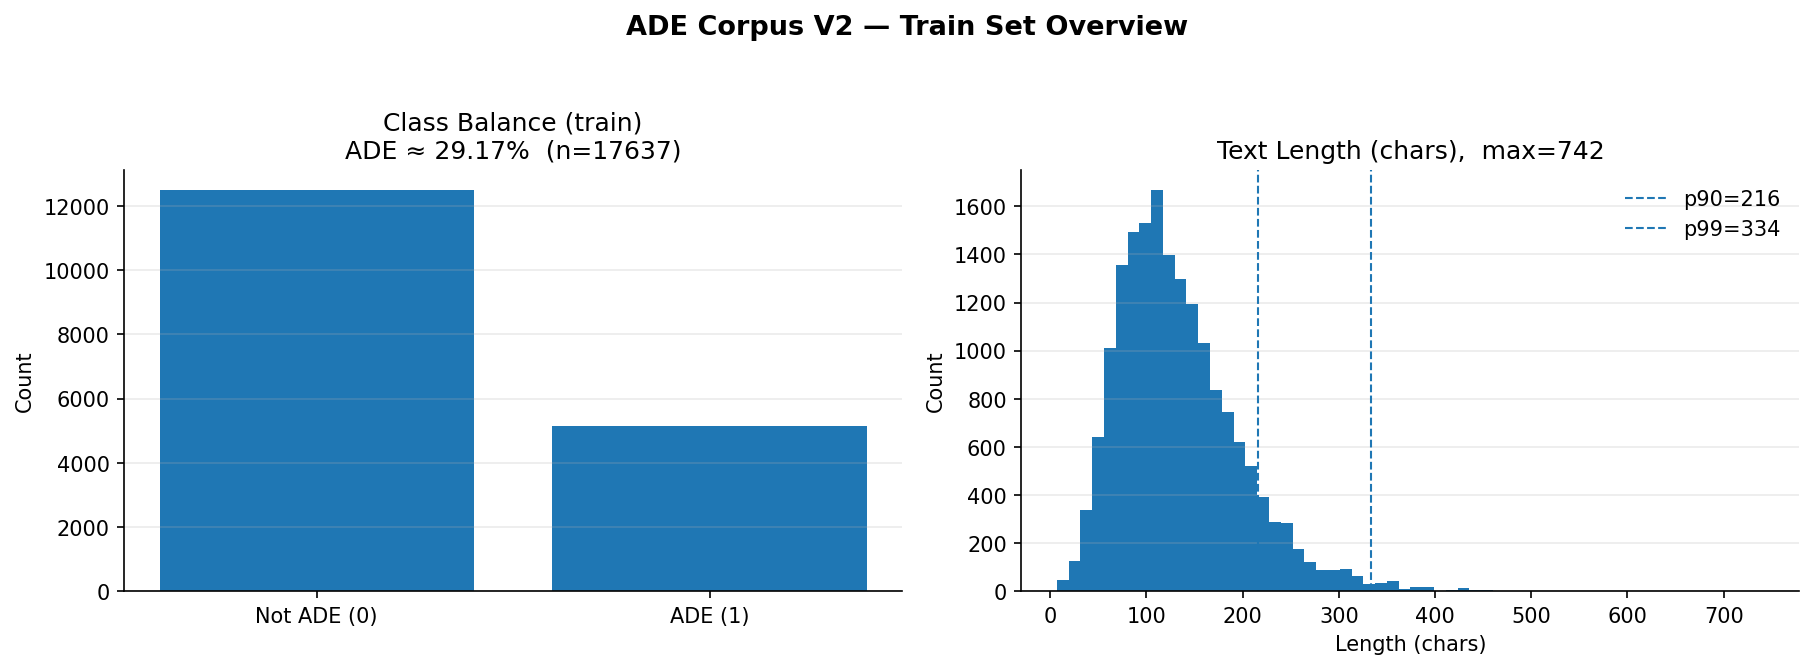

In [ ]:
show_img(PLOTS_DIR / "eda_overview.png", width=1300)

### **Notes on the plots**
- Class balance is skewed toward Not ADE, which motivates class-weighted loss and careful threshold selection.
- Text length distributions are similar across splits, which lowers the risk of a split-specific shift.



### **Cleaning and leakage guard**

- Dropped empty texts and de-duplicated by `text_clean`  
  removed: train = 1,718; test = 253
- Removed train-test overlaps by `text_norm`  
  removed: 649 rows from train
- Stratified split (seed 42)  
  train = 13,743, val = 1,527, test = 5,626
- Class weights for imbalance  
  {0: 0.3719711853307138, 1: 1.628028814669286}


# **split is stratified with a fixed seed (42)**

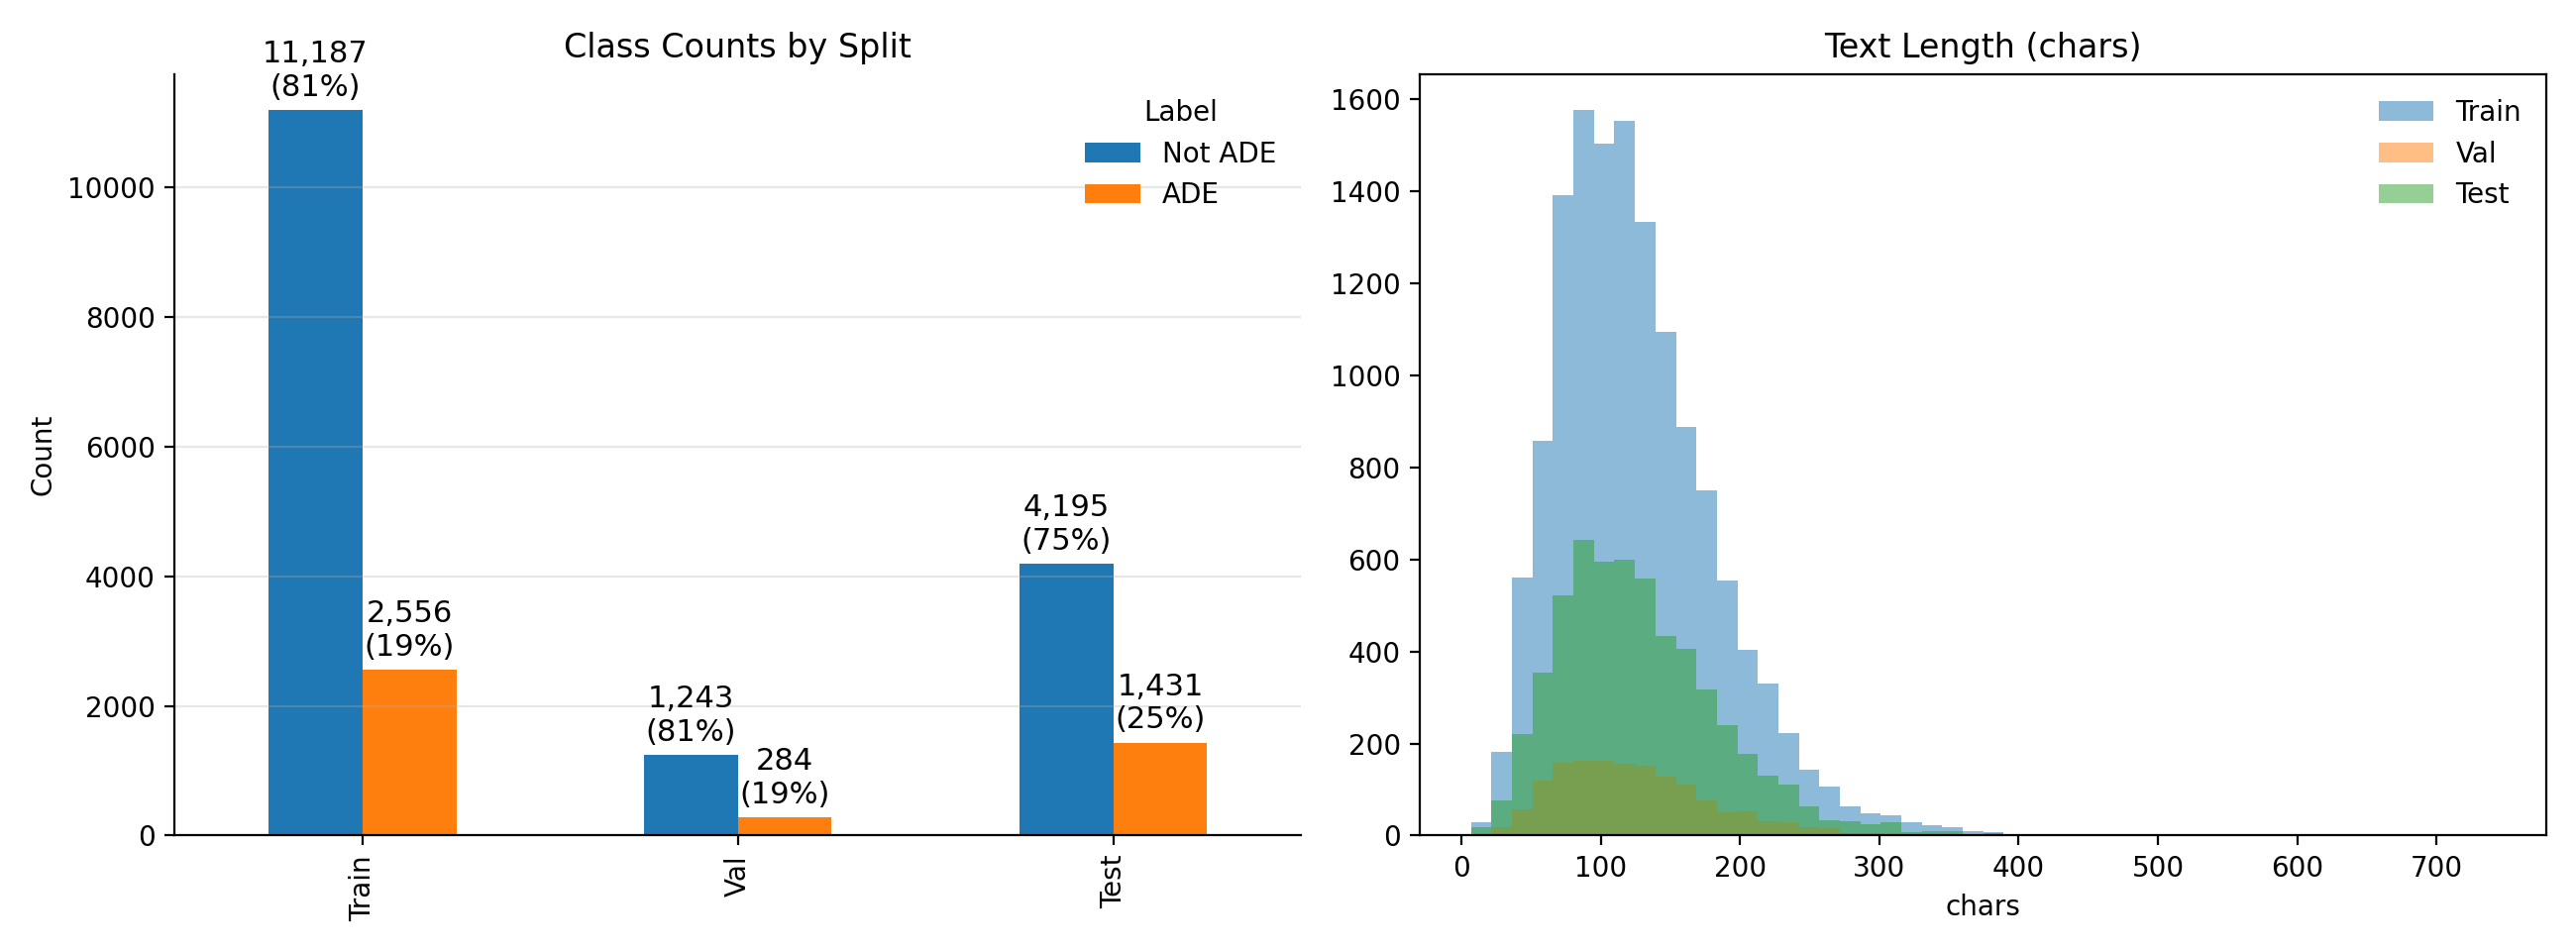

In [ ]:
show_img(PLOTS_DIR / "row_counts_lengths_by_split.png", width=1300)

Splits remain stratified and imbalanced: train and validation have about 19 percent ADE; test has about 25 percent ADE.

Row counts are about 13,743 for train, 1,527 for validation, and 5,626 for test.

Length distributions overlap closely across splits, which suggests no major distribution shift.

Most examples in all splits are under about 250 to 300 characters.

One tokenizer max length can be used across splits without introducing split-specific artifacts.

# **Exploratory Data Analysis**
### Notebook 2
- EDA — [Colab](https://colab.research.google.com/drive/1ixGcdCv_moL-CagZ51qLHigC-btEgLCk)

### **What we looked for**

Negation, temporal cues, and drug-like terms by class.

Length distributions by class to check for simple confounds.

Top bigrams and unigrams that characterize each class.

TF-IDF differences to see which phrases lean ADE vs Not-ADE.

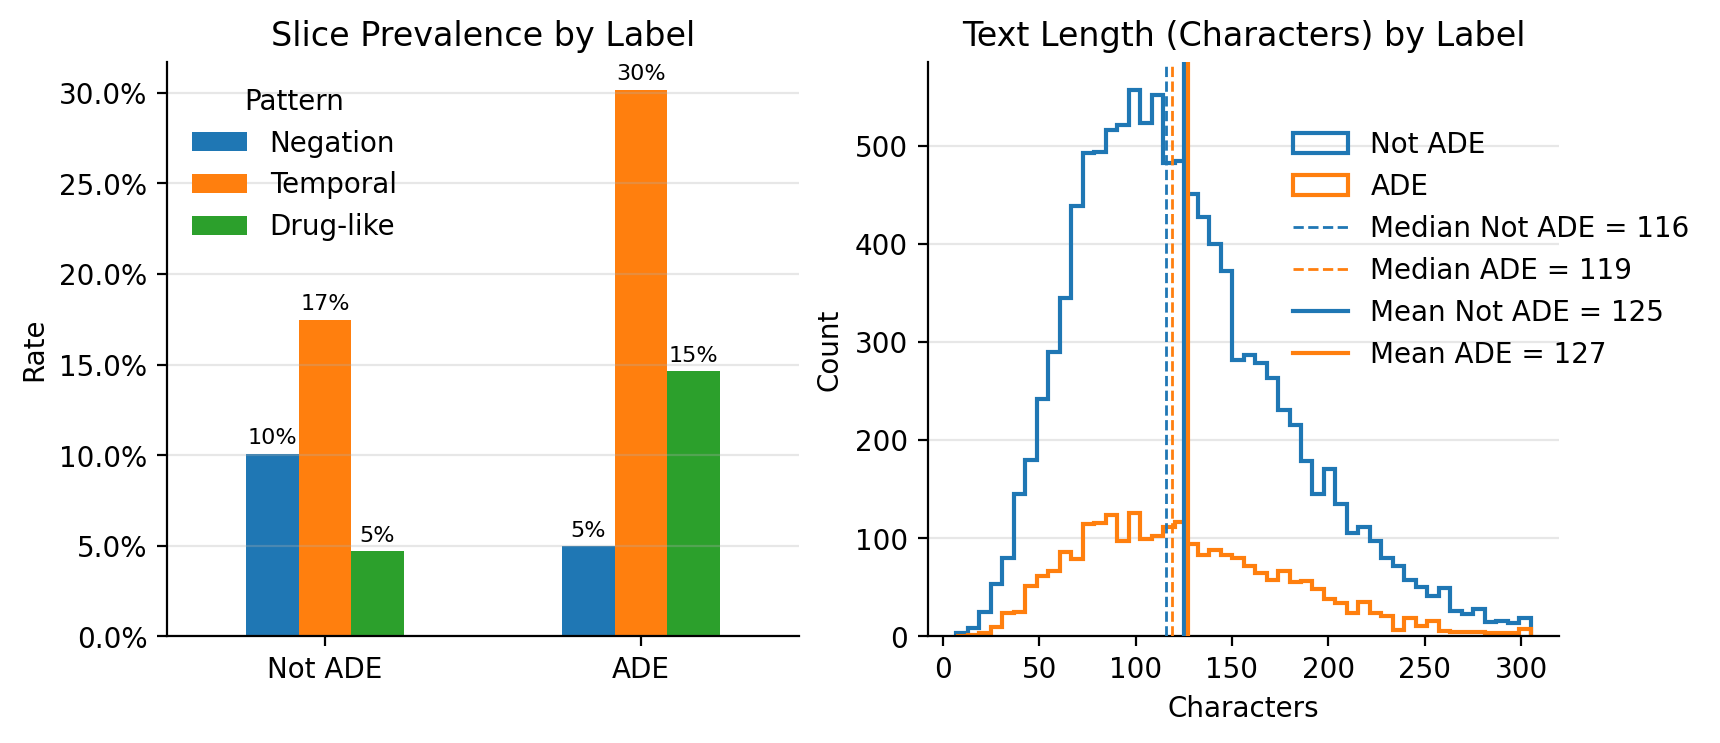

In [ ]:
show_img(PLOTS_DIR / "edaA_slices_len_by_label.png", width=1100)

**Negation:** no, not, denies, without, negative for.
**Temporal:** after, following, immediately, onset, worsened, developed.
**Drug-like:** stems such as pril, sartan, statin, cillin, mycin, cycline, mab, zolam, zepam, azole, olol, dipine, caine, oxetine, pramine, prazole, afil, formin.

Temporal cues are more common in ADE, about 30 percent vs about 17 percent in Not-ADE.

Drug-like terms are more common in ADE, about 15 percent vs about 5 percent.

Negation is more common in Not-ADE, about 10 percent vs about 5 percent.

Length profiles are very similar across labels; means are about 125 to 127 characters and medians about 116 to 119.

A linear baseline with bigrams can use these signals; length is unlikely to confound results.

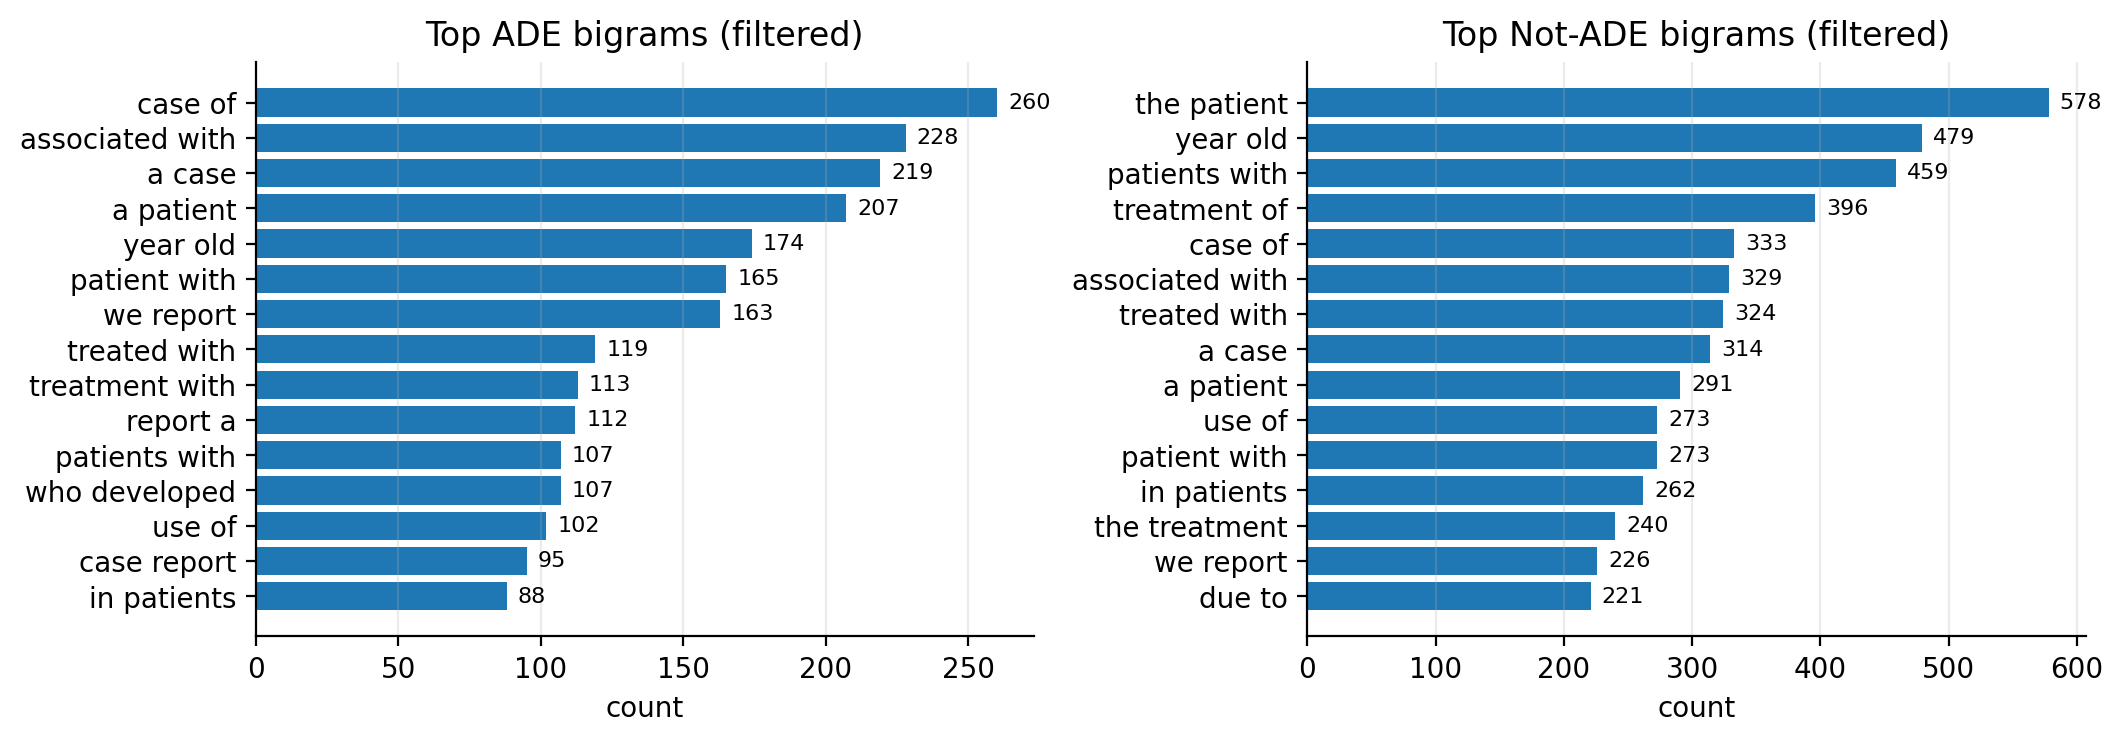

In [ ]:
show_img(PLOTS_DIR / "edaB_top_bigrams_by_label_filtered.png", width=1400)

ADE highlights reporting and causal phrases such as “case of,” “associated with,” “treated with,” and “who developed.”

Not-ADE includes generic report scaffolding like “the patient” and “year old,” plus shared clinical phrases.

Phrase features should help because many ADE bigrams encode sequence or causality.

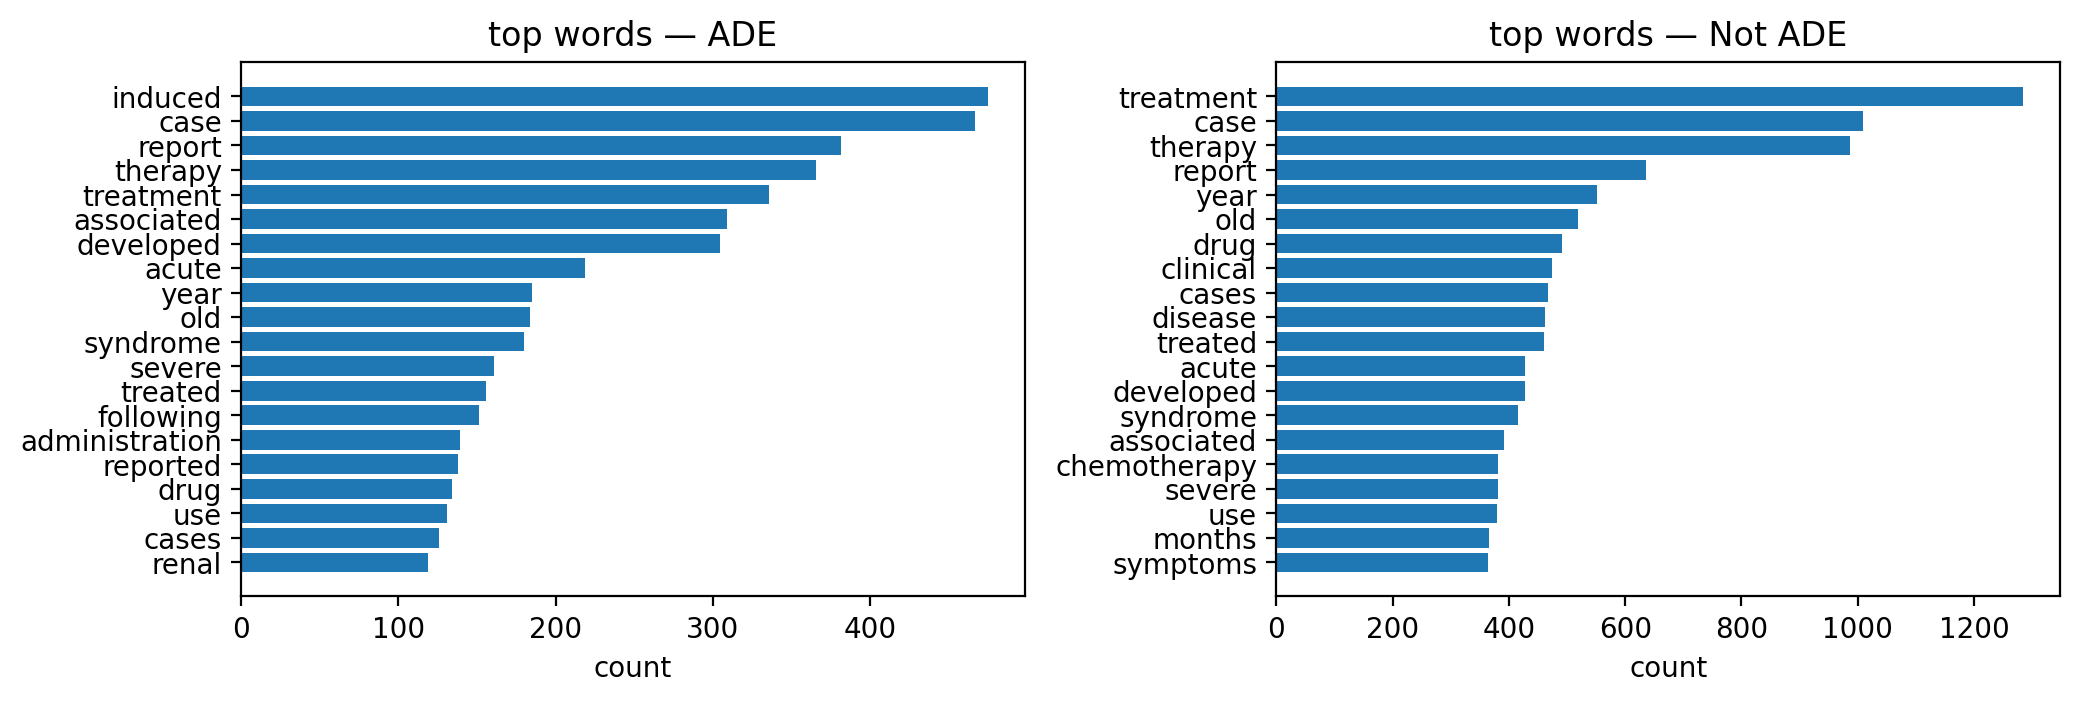

In [ ]:
show_img(PLOTS_DIR / "edaC_top_unigrams_by_label.png", width=1400)

ADE emphasizes event words such as induced, associated, developed, toxicity, and acute.

Not-ADE leans toward broader clinical context words.

Overlap is expected; uni-grams plus bi-grams with TF-IDF will separate classes better.

Domain stopwords remove dosing boilerplate and keep content words.

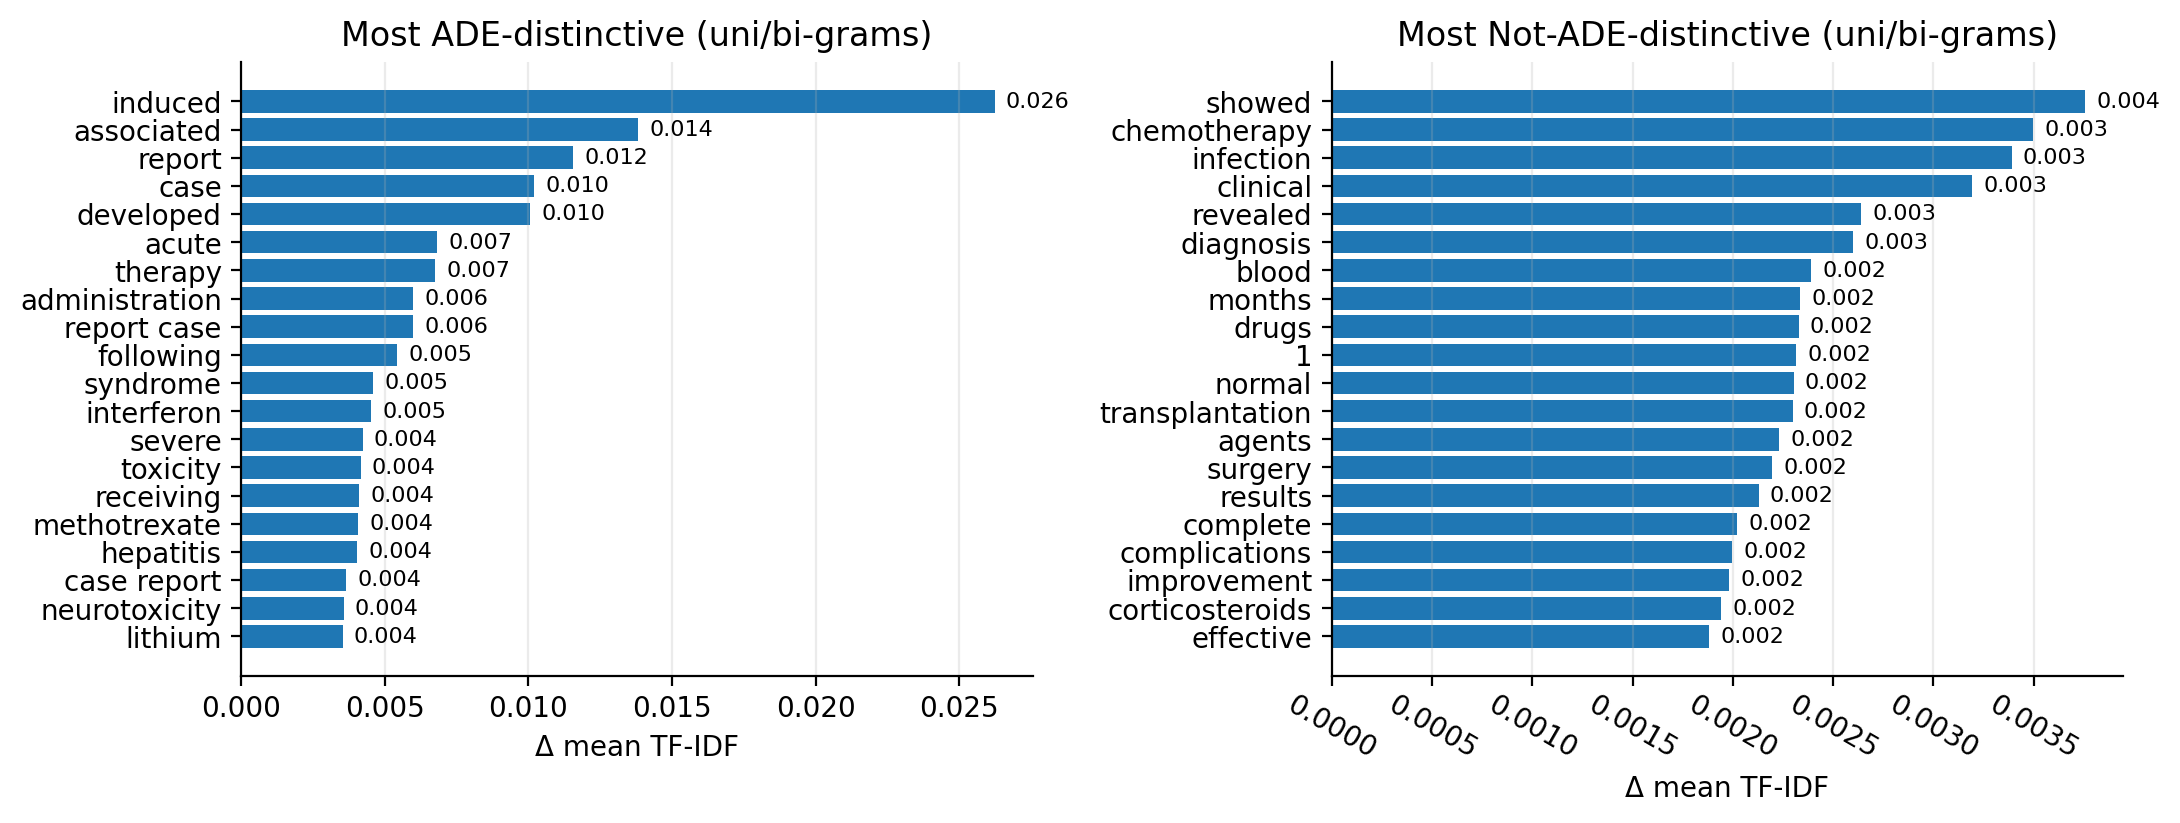

In [ ]:
show_img(PLOTS_DIR / "edaD_top_TF_IDF_by_label.png", width=1400)

Left panel shows terms with higher mean TF-IDF in ADE, including induced, associated, report, developed, toxicity, hepatitis, and interferon. Right panel shows terms with higher mean TF-IDF in Not-ADE, including showed, chemotherapy, infection, diagnosis, surgery, transplantation, and improvement.

The absolute differences are small but consistent and align with earlier unigram and bigram views. ADE language skews toward causality and outcomes; Not-ADE skews toward general clinical context.

These results support using uni-grams and bi-grams with TF-IDF for the baselines and for model interpretation later.

### **Key takeaways from EDA**

Temporal cues and drug-like terms are more common in ADE; negation is more common in Not-ADE.

Length distributions are similar across classes, so length is unlikely to confound results.

ADE phrases often encode causality or onset wording such as associated with and developed.

TF-IDF differences highlight clinical terms that separate the classes, which supports both linear baselines and transformers.

# **Models**



- Notebook 3: Baselines (TF-IDF LR/SVM) — [Colab](https://colab.research.google.com/drive/1swGOnQTKFJ7AdwWeURLvads2kpBqzPDn)
- Notebook 4: DistilBERT — [Colab](https://colab.research.google.com/drive/1UgOQA5L0S4m-OsTCVY9f7aONCPcykmDV)
- Notebook 5: BioBERT — [Colab](https://colab.research.google.com/drive/1LQNZSgwLzN2GjOGNEZjUZJfOsTvFC6yl)
- Notebook 6: PubMedBERT — [Colab](https://colab.research.google.com/drive/1C3idcaweut3V4hxMf5zcCIPhbJTmDJVb)
- Notebook 7: Model comparison — [Colab](https://colab.research.google.com/drive/13uH5BAeFE8lAn_SQUXn-fzp_viRNqXMh)


# Why these models and model-specific settings

## TF-IDF Logistic Regression
- **Why**: Strong linear baseline for short clinical text. Fast to train, easy to interpret feature weights, and sets a reference point for gains from deep models.
- **Settings**: TF-IDF unigrams and bigrams, up to fifty thousand features, liblinear solver, class weights from training labels.

## TF-IDF Linear SVM
- **Why**: Classic high margin linear classifier that often beats logistic regression on sparse n gram features. Calibrated to produce usable probabilities.
- **Settings**: LinearSVC with class weights, wrapped in CalibratedClassifierCV with sigmoid and three fold internal calibration to produce probabilities.

## DistilBERT
- **Why**: Lightweight transformer with general English pretraining. Tests whether contextual models help beyond bag of words without heavy domain pretraining.
- **Settings**: distilbert base uncased, maximum token length three hundred twenty, batch size sixteen for training and sixty four for evaluation, AdamW learning rate five times ten to the minus five, early stopping with patience of two epochs on validation recall, load the best checkpoint.

## BioBERT
- **Why**: Pretrained on biomedical literature. Tailored vocabulary and representations for drug, event, and clinical phrasing in ADE text.
- **Settings**: dmis lab biobert base cased v1.1 with the same maximum length, batch sizes, optimizer, early stopping, and selection metric as DistilBERT.

## PubMedBERT
- **Why**: Pretrained from scratch on PubMed abstracts. Often excels on biomedical classification where domain wording and context matter.
- **Settings**: microsoft BiomedNLP PubMedBERT base uncased abstract with the same maximum length, batch sizes, optimizer, early stopping, and selection metric as DistilBERT.


---

# Rules we followed for every model

- Use the same cleaned splits from Notebook 1 with a fixed random seed.  
- Counter class imbalance with class-weighted loss.  
- **Choose a decision threshold on validation to meet a recall floor of 0.90.  
The procedure maximizes precision while meeting the recall target (a tie break on f1).**
- Apply that same validation-chosen threshold on the test set to keep the comparison fair.  
- Report precision, recall, F1, accuracy, PR AUC, and ROC AUC.  

---

In [ ]:
#comparison table

cmp_csv = Path(ARTIFACTS_DIR /"comparison/all_models_summary.csv")
cmp_df = pd.read_csv(cmp_csv)
cmp_df = cmp_df.drop(columns=["meets_val_floor"], errors="ignore")
cmp_df

,model,thr,VAL_P,VAL_R,VAL_F1,VAL_AP,VAL_AUC,TEST_P,TEST_R,TEST_F1,TEST_Acc,TEST_AP,TEST_AUC,TEST_TN,TEST_FP,TEST_FN,TEST_TP,eligible
0,biobert,0.776644,0.837134,0.904930,0.869712,0.936137,0.984474,0.896312,0.900070,0.898187,0.948098,0.946381,0.978224,4046,149,143,1288,True
1,pubmedbert,0.875574,0.831715,0.904930,0.866779,0.927376,0.980226,0.887902,0.907757,0.897719,0.947387,0.947958,0.983409,4031,164,132,1299,True
2,tfidf_svm,0.125426,0.416260,0.901408,0.569522,0.710548,0.901964,0.498459,0.904263,0.642662,0.744223,0.778469,0.900236,2893,1302,137,1294,True
3,distilbert,0.548250,0.769461,0.904930,0.831715,0.901197,0.975246,0.821290,0.889588,0.854076,0.922680,0.923133,0.974646,3918,277,158,1273,False
4,tfidf_logreg,0.376071,0.418301,0.901408,0.571429,0.667119,0.887330,0.500977,0.895877,0.642607,0.746534,0.754870,0.891482,2918,1277,149,1282,False


### Reading the comparison table

- **Who meets the rule:** BioBERT and PubMedBERT are **eligible** (test recall ≥ 0.90 at the validation-chosen threshold). DistilBERT and TF-IDF Logistic Regression fall just below the recall floor on test; TF-IDF SVM clears the floor but with low precision.
- **Top two are a near tie:**  
  - **BioBERT:** P 0.896, R 0.900, F1 0.898, AP 0.946, AUC 0.978.  
  - **PubMedBERT:** P 0.888, R 0.908, F1 0.898, AP 0.948, AUC 0.983.  
  Metrics are essentially equal; PubMedBERT trades a bit of precision for more recall.
- **Error trade-off (counts):**  
  - **BioBERT:** FP 149, FN 143.  
  - **PubMedBERT:** FP 164, FN 132.  
  PubMedBERT has **11 fewer false negatives** at the cost of **15 more false positives**. If missing ADEs is costlier, this favors PubMedBERT.
- **Baselines:** TF-IDF SVM reaches the recall floor (R 0.904) but precision is low (P 0.498). TF-IDF Logistic Regression misses the floor on test (R 0.896). Both are dominated by the transformers.

**Bottom line:** Both BioBERT and PubMedBERT satisfy the requirement; **PubMedBERT** slightly improves recall with the same F1, so it is the safer choice when recall is prioritized.


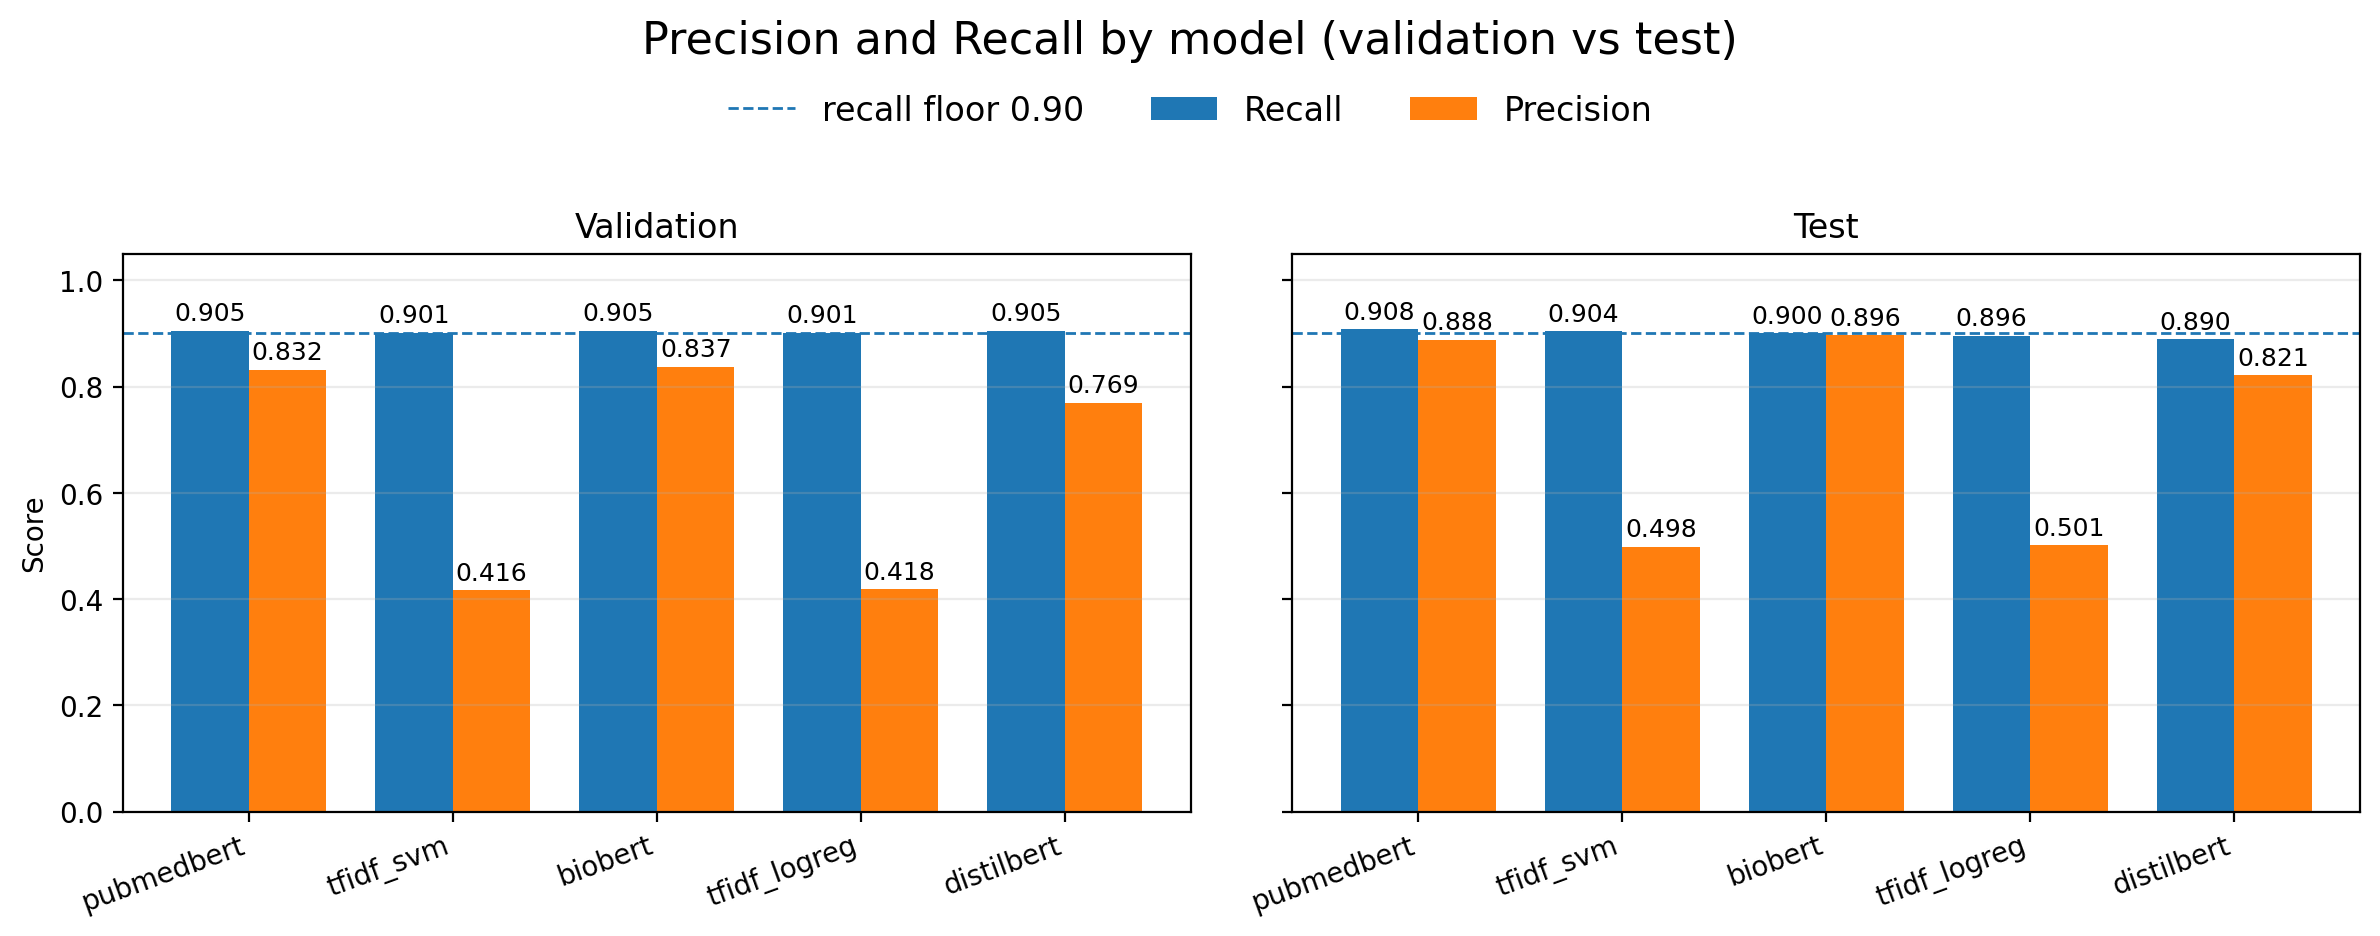

In [ ]:
show_img(PLOTS_DIR / "comparison/cmp_precision_recall_bars.png", width=1300)

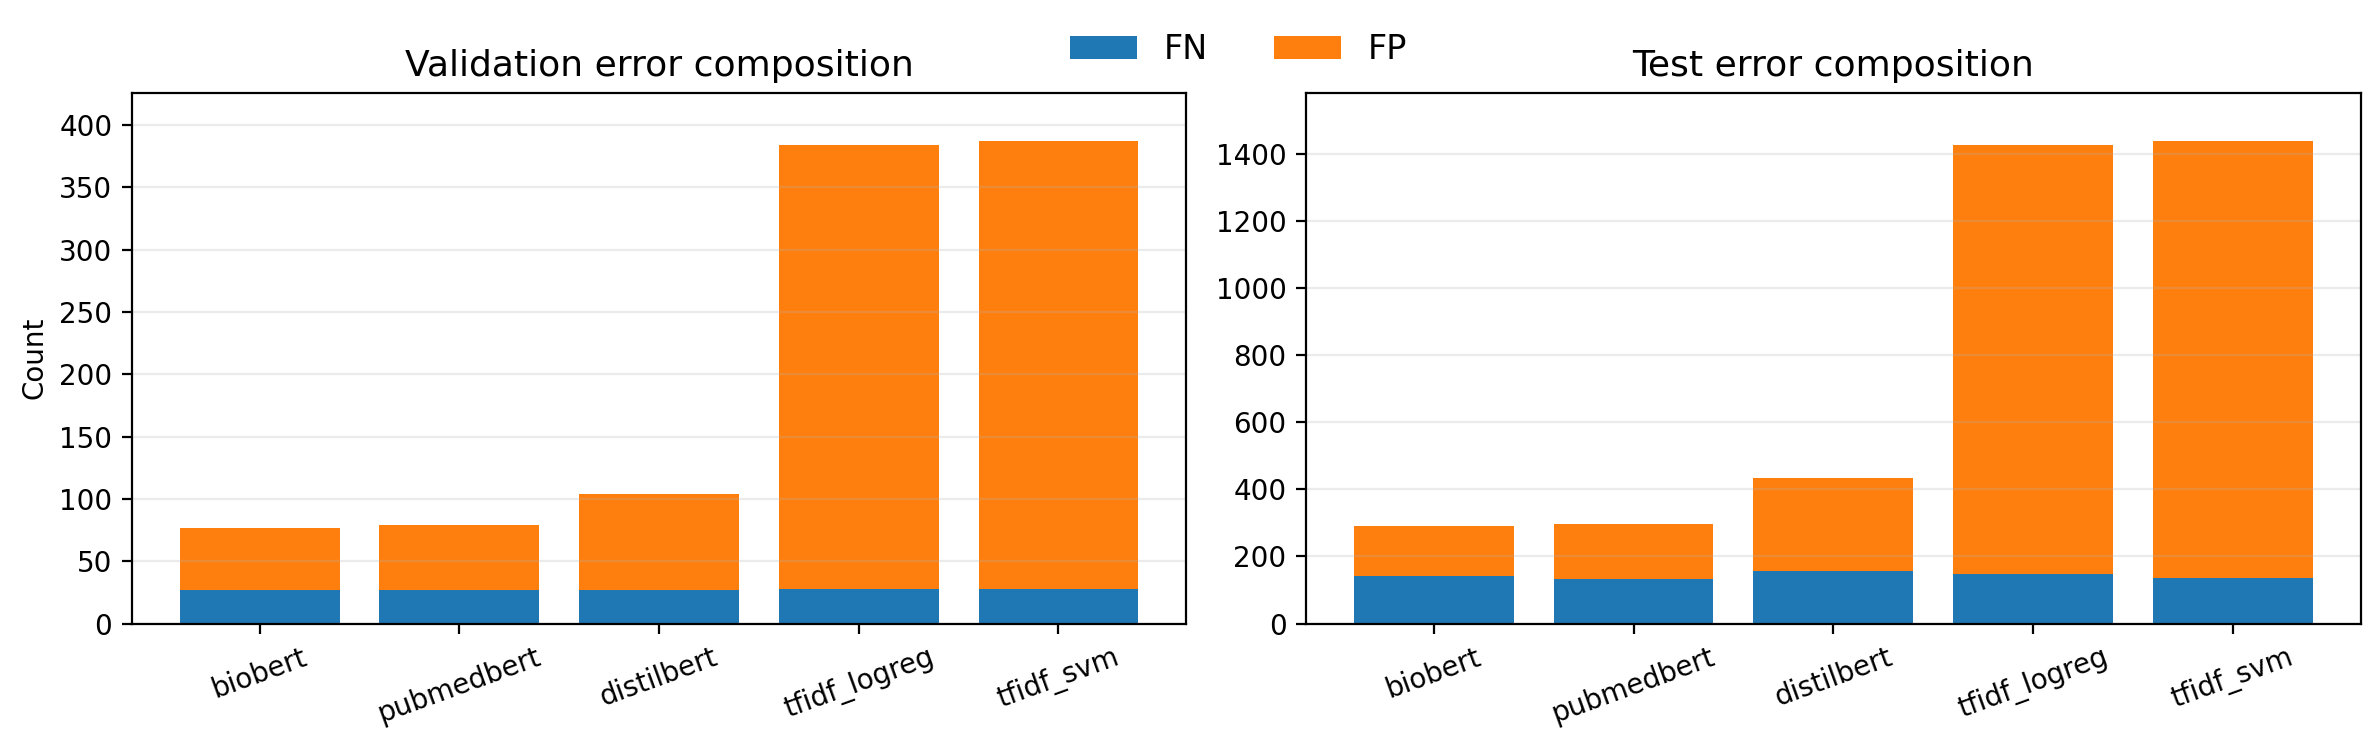

In [ ]:
show_img(PLOTS_DIR / "comparison/cmp_error_composition_val_test.png", width=1300)

### What the plots show

- **Overall:** Transformer models outperform TF-IDF baselines by a wide margin on Precision.
- **Precision and recall bars:** PubMedBERT and BioBERT both meet the 0.90 recall floor (evaluated on test at validation-chosen thresholds). PubMedBERT has the highest recall with a small precision tradeoff; BioBERT has the best precision at nearly the same recall. DistilBERT is close but falls short of the recall floor and slightly lower on precision.
- **Error composition:** Transformers sharply reduce false positives compared with TF-IDF. PubMedBERT yields the fewest false negatives among the top models, which supports the recall goal.

## Chosen model

**Selection rule**  
- Fix the threshold on validation to meet a recall floor of 0.90.  
- On test, among models that meet the floor, prefer higher precision. If tied, use F1, then PR AUC.

**Decision**  
- **PubMedBERT** is selected. It meets the recall floor, delivers the highest recall on test, and remains competitive on precision and F1. This matches the goal of minimizing false negatives while accepting a small increase in false positives.

**Model- PubMedBERT**  
- Between two near ties (PubMedBERT and BioBERT), we favor the model with higher recall since missing an adverse event is costlier than reviewing a few extra false positives.


---------------------------
---------------------------
# **Why the models performed this way**

**TF-IDF Logistic Regression**: Sees independent n-grams; catches ADE keywords (e.g., developed, associated with) but misses negation and temporal scope, leading to more false positives at the recall-floor threshold.

**TF-IDF Linear SVM (calibrated)**: High-margin linear decision and recall-floor tuning raise recall, but the same bag-of-words limits keep precision comparatively low.

**DistilBERT**: Contextual embeddings capture order, negation, and cues, giving a clear lift over TF-IDF; general-English pretraining underfits biomedical phrasing compared with domain models.

**BioBERT**: Biomedical pretraining understands drug/event phrasing better, yielding the highest precision at similar recall and filtering non-ADE scaffolding more cleanly.

**PubMedBERT**: Pretrained from scratch on PubMed; tokenizer and vocabulary fit domain terms well, producing the fewest false negatives (highest recall) with only a small precision trade-off.

---------------------------
---------------------------



# **PubMedBERT**
### Closer look

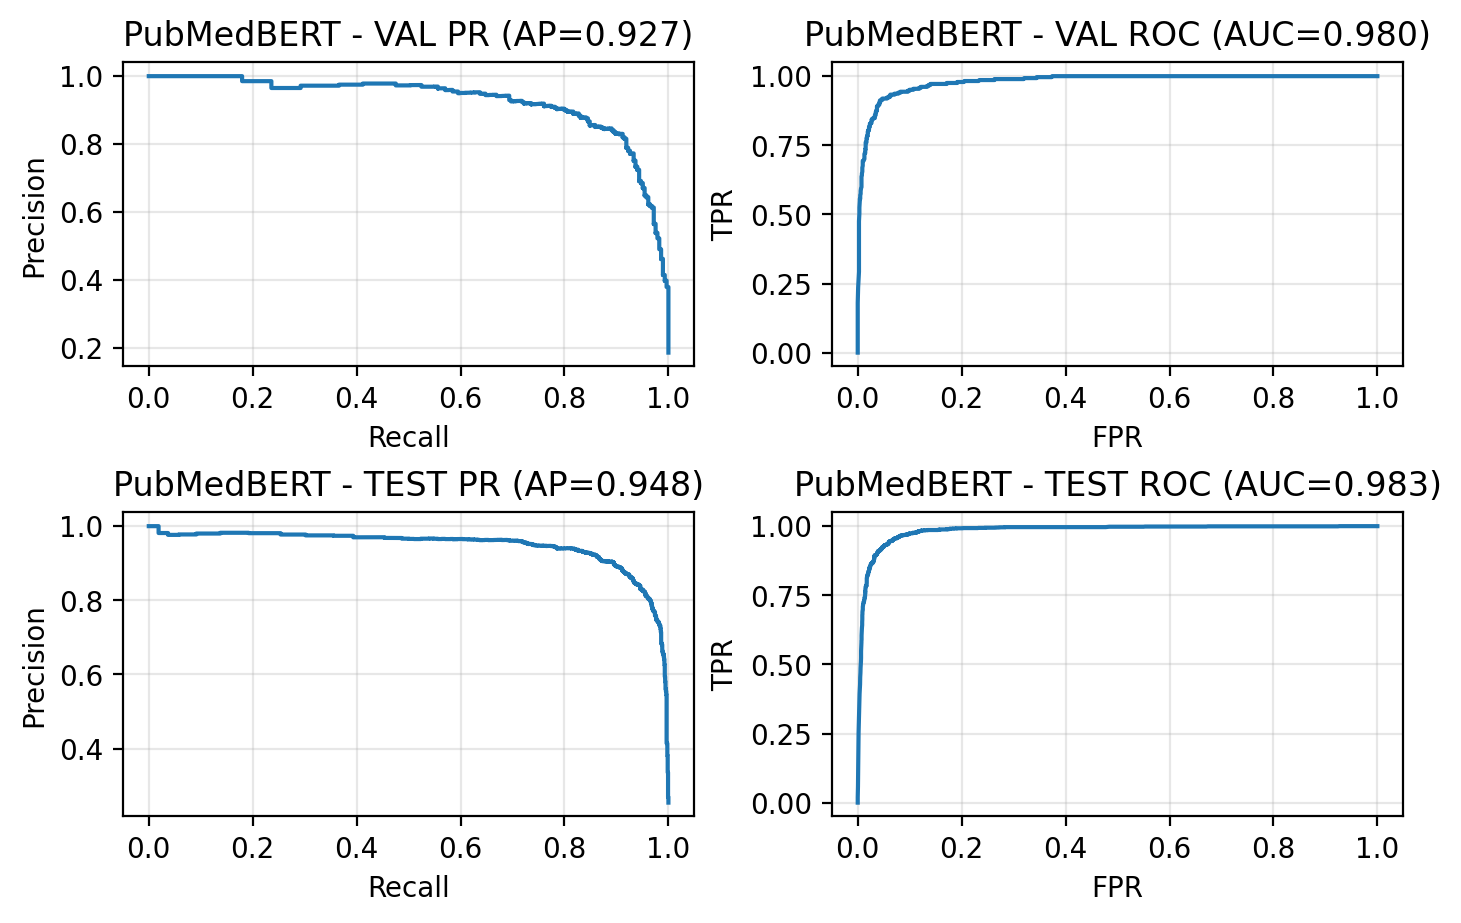

In [ ]:
show_img(PLOTS_DIR / "pubmed_val_test_pr_roc_grid.png", 900)

### PubMedBERT — PR and ROC takeaways

- Strong and stable curves: PR AUC rises from 0.927 (val) to 0.948 (test); ROC AUC remains high at 0.980 (val) and 0.983 (test).
- Steep left shoulder on ROC and a flat high-precision region on PR show good separation, especially at high recall.
- At the validation-chosen threshold (recall floor 0.90), test precision is 0.888 and F1 is 0.898.
- Minimal drift from validation to test suggests low overfitting and good generalization.
- Given class imbalance, PR is more diagnostic; these curves support prioritizing recall without a major loss in precision.

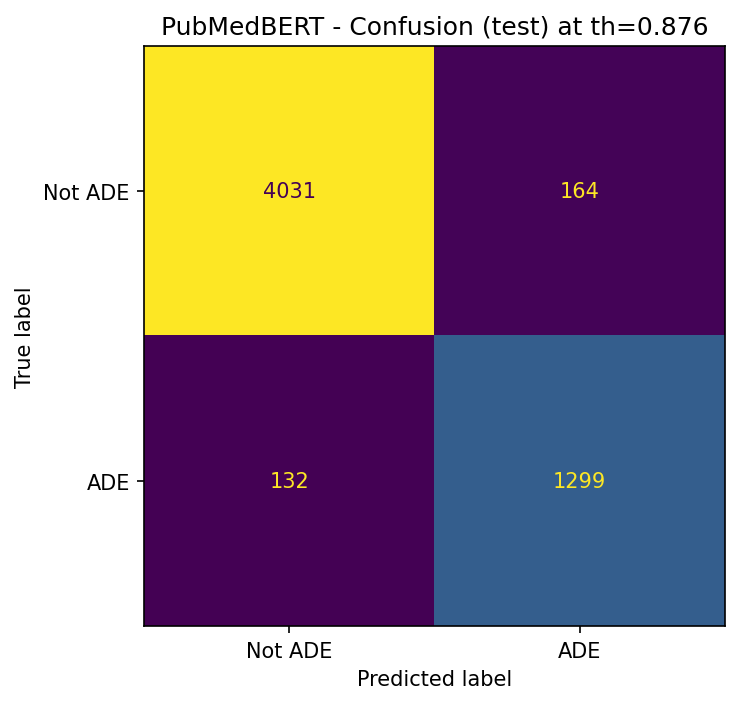

In [ ]:
show_img(PLOTS_DIR / "pubmed_test_confusion.png", 530)

### PubMedBERT — Confusion matrix (test, th = 0.876)

**Counts:** TN 4031, FP 164, FN 132, TP 1299  
**Metrics:** Precision = 0.888 , Recall = 0.908 , F1 = 0.898 , Accuracy = 0.947 , Specificity = 0.961

- Meets the **recall floor** while keeping precision competitive.
- Most negatives are correctly rejected (low FPR = 3.9%).
- **FN = 132** (lower than BioBERT's 143 in our table) which aligns with the recall-first objective.
- Error mix: total errors 296 = 164 FP + 132 FN (FN = 45% of errors).
- Practical read: among 100 true ADE cases,  9 are missed; among 100 flagged as ADE,  11-12 are false alarms.
- If even higher recall is required, lowering the threshold will reduce FN further at the cost of more FP (see PR curve).



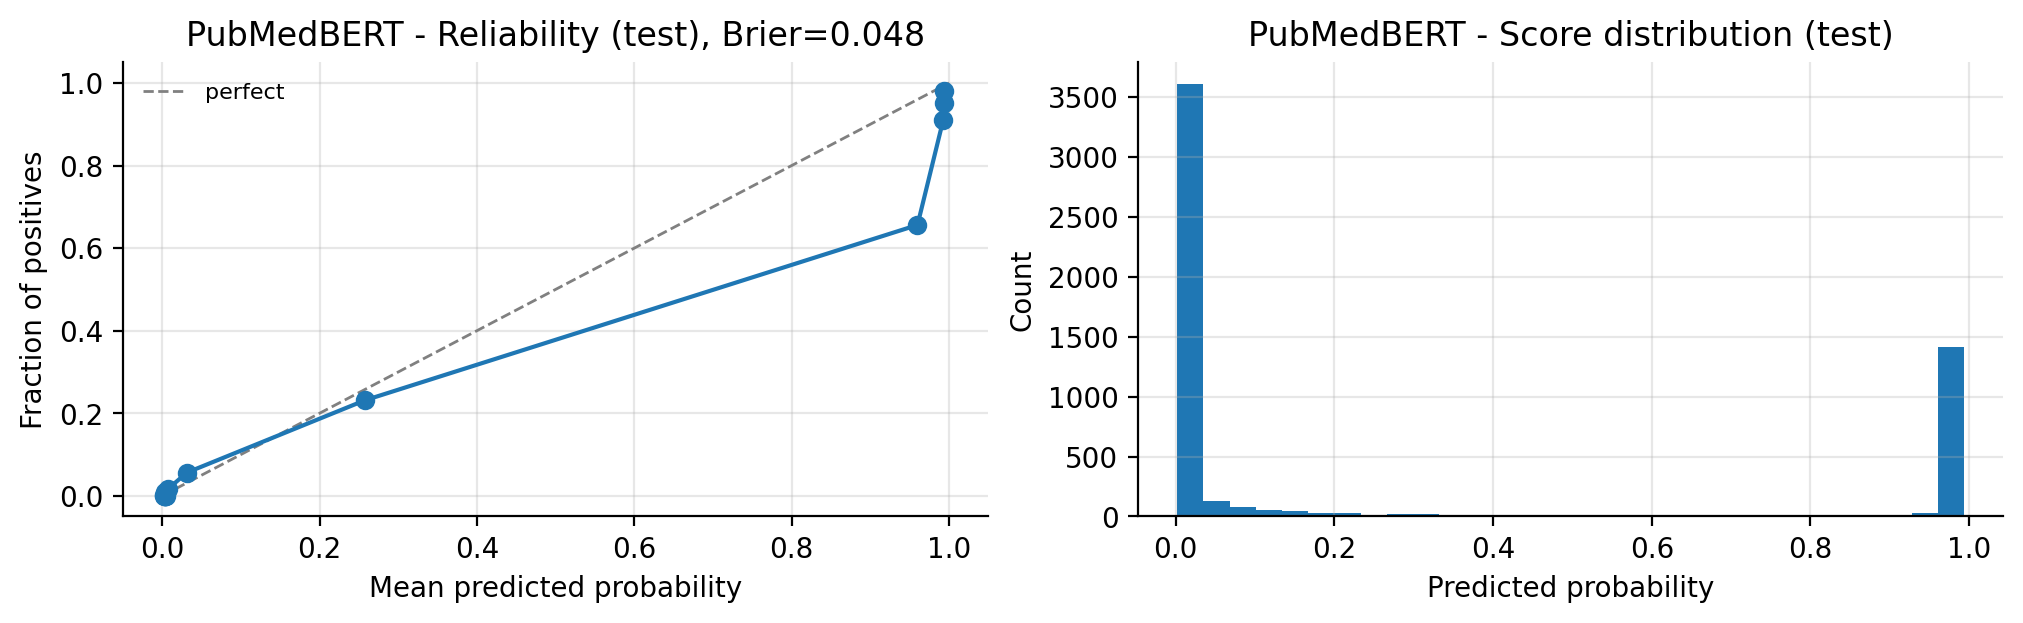

In [ ]:
show_img(PLOTS_DIR / "pubmed_test_calib_and_hist.png", 1200)

### PubMedBERT — Reliability and score distribution (test)

**Brier score:** 0.048

- Calibration curve tracks the diagonal well, with only mild underconfidence in mid-range bins and slight overconfidence at the extreme right.
- Histogram shows a clean separation: most non-ADE near zero, a large block of ADE near one, and a small middle tail.
- This shape supports stable thresholding. can raise recall by lowering the threshold with a predictable precision trade-off.
- Well-calibrated probabilities are suitable for downstream risk scoring and ensembling.


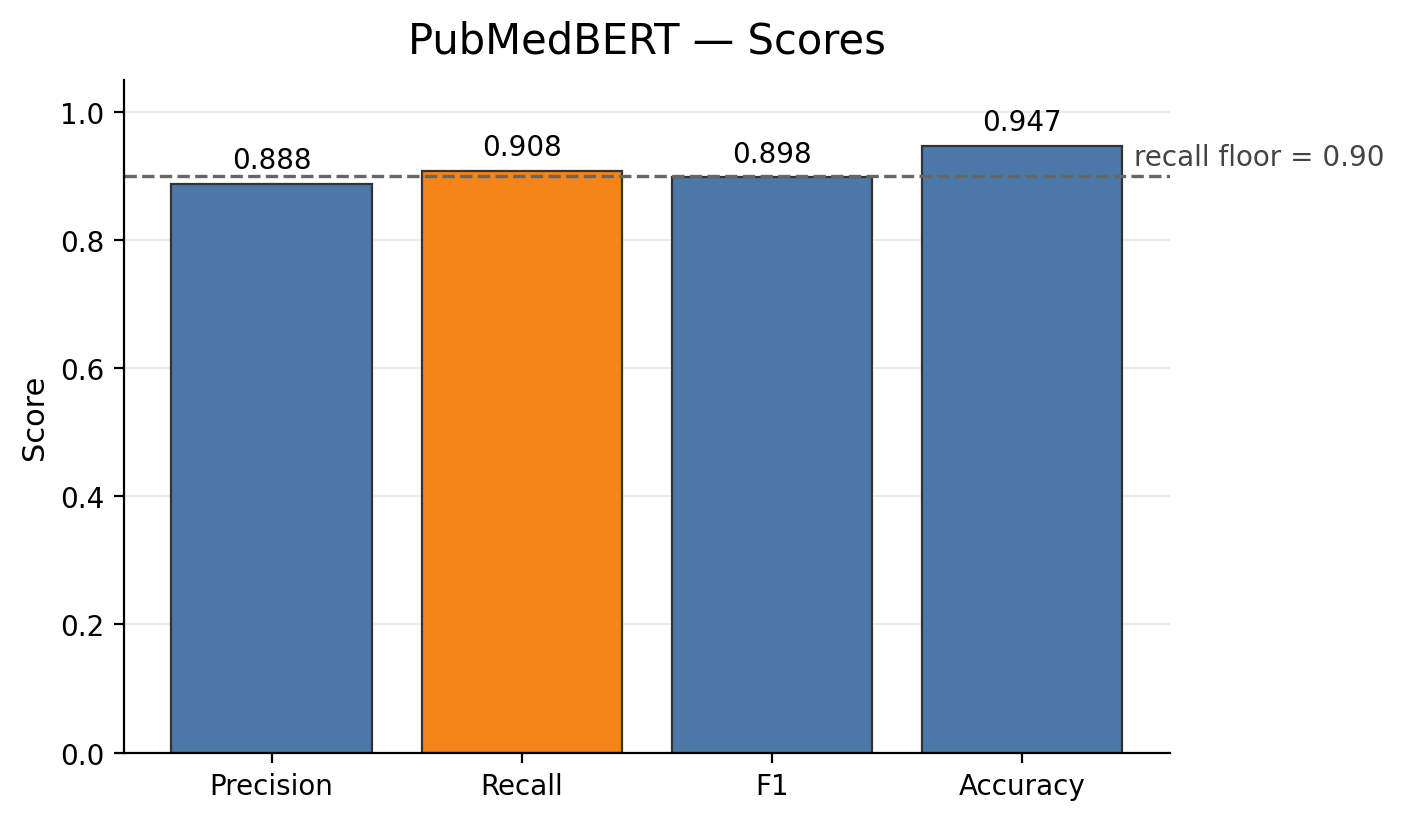

In [ ]:
show_img(PLOTS_DIR / "comparison/pubmedbert_test_metrics_bars.png", 800)

---------------------------
---------------------------

# **Conclusion**

Task: detect adverse drug events in short biomedical text with a recall priority.

Winner: PubMedBERT at the validation chosen threshold.

Test metrics: Precision 0.888, Recall 0.908, F1 0.898, Accuracy 0.947, PR AUC 0.948, ROC AUC 0.983.

Errors: FP 164, FN 132. Compared with BioBERT, PubMedBERT reduces false negatives by 11 at the cost of 15 more false positives.

Why this choice: under a recall first policy, missing fewer ADEs is preferred. PubMedBERT keeps precision competitive while lifting recall to the target.

**What worked**

Clean splits and leakage guard helped generalization.

Recall floor selection on validation enforced the project goal and kept test scoring fair.

Domain pretraining mattered. PubMedBERT and BioBERT clearly outperformed TF IDF baselines and DistilBERT.

Calibration was reasonable. Brier score 0.048 with a near diagonal reliability curve, which supports threshold control.



---------------


------------------------

### **Deployment**

# **Demo**

**Live demo:** [![🤗 Space](https://img.shields.io/badge/%F0%9F%A4%97%20Space-ADE--PubMedBERT-blue)](https://huggingface.co/spaces/Daregay/ade_pubmedbert_demo)

The working demo is live on Hugging Face Spaces — : https://huggingface.co/spaces/Daregay/ade_pubmedbert_demo

**Small further work for demo listed below**

--------------------

## Important caveats and limitations

- **Domain shift:** Source sentences are from published case reports. Performance may differ on other domains such as clinical notes, social media, or regulatory narratives.
- **Class imbalance:** Not-ADE sentences are more common. We address this by class-weighted loss and by threshold selection that enforces a **recall floor**.
- **Annotation noise:** Sentence-level labels simplify a richer relation task; borderline cases and context outside the sentence can affect labels.
- **Ethics and safety:** The model is not a diagnostic tool. Use in a human-review loop. False negatives carry patient-safety risk; false positives add reviewer load—both are tracked in our error analyses.


---------------------------

#**Further work**

**Data and labeling:**

Broaden sources: add a small sample of clinical note snippets or regulatory case narratives to reduce domain shift from case reports.

Tighten labels: review a slice of false negatives and false positives to fix borderline or noisy labels and feed them back for a quick fine-tune.

**Threshold and calibration**

Cost-aware threshold: choose the operating point on validation using an explicit FN vs FP cost ratio instead of a fixed floor.

Calibration pass: apply temperature scaling or isotonic regression on validation, then re-pick the threshold. This stabilizes precision at high recall.

**Deployment Further Work**

Curated examples: Add 8-12 short sentences covering: clear ADE, clear Not-ADE, tricky negation, temporal cues, drug names, rare ADE. This shows strengths/limits.

Inline threshold explainer: A one-liner under the slider: “Lowering the threshold increases recall and false positives; raising it does the opposite.”

Confidence display: Show both probabilities (ADE and Not-ADE) and the active threshold so users see why a decision flipped.

Theme + layout polish: Use a clean Gradio theme, center the interface, add a footer link to README and notebooks.

#**Acknowledgments and references**

Dataset: ADE Corpus V2 sentence classification on Hugging Face.

Models: PubMedBERT, BioBERT, and DistilBERT from the Transformers library.

Methods: standard text classification practice with TF IDF baselines and transformer fine tuning, plus validation based threshold selection to enforce a recall target.

### *Git*

In [50]:
%%bash
git push

To github.com:daregay/Adverse_Drug_Events_capstone.git
   0b6ade5..b5698f3  main -> main
